In [2]:
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
import numpy as np
from matplotlib import font_manager, rc # 폰트 세팅을 위한 모듈 추가
import matplotlib.pyplot as plt 
import seaborn as sns
# matplotlib이 한글을 읽을 수 있도록 변경  
plt.rcParams['axes.unicode_minus'] = False
font_path = "C:/Windows/Fonts/malgun.ttf" # 사용할 폰트명 경로 삽입
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

#파일을 읽어옴
df = pd.read_excel("./DS.xlsx")

# <군집분석>

### 1. 데이터 전처리
#### 1) '분위수' 관련 column 삭제

In [1]:
# # '분위수'관련 column 삭제
# # 추출할 열의 인덱스 리스트 => 구글 문서에 열 이름 별 인덱스 적어놓음!!
# column_indices = [0, 3, 4, 5, 6, 8, 13, 18, 23, 28, 33, 39, 43, 47, 51, 55, 59, 64, 69, 74, 79, 84, 89, 94, 99, 104, 109, 114, 119, 124, 129, 134, 139]

# # 열 이름 추출
# column_names = [df.columns[i] for i in column_indices if i < len(df.columns)]

# # 추출된 열들로 새로운 데이터프레임 생성
# df_selected = df[column_names]

# # 상관행렬 계산
# correlation_matrix = df_selected.corr()

# # 상위 삼각형 마스킹 배열 생성 => 하위 삼각형만 보기 위해서
# mask_upper = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# # 상관 계수의 절대값이 0.7 이하인 값들을 마스크 처리 => 상관계수 절댓값이 0.7 이상인 것들만 모아 볼 수 있도록
# mask_correlation = np.abs(correlation_matrix) < 0.7

# # 두 마스크를 결합
# mask_combined = mask_upper | mask_correlation

# # 마스크된 값을 NaN으로 변환 (히트맵에서 보이지 않도록)
# correlation_matrix = correlation_matrix.mask(mask_combined)

# # 히트맵 시각화
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, mask=mask_upper, cbar=False)
# plt.title('Correlation Heatmap (|correlation| > 0.7, Lower Triangle)')
# plt.show()

- (배달 서비스 사용일수)에 대한 상관계수가 0.7 이상인 것들[column_num]: 연령대[4], 데이터 사용량[59], 금융서비스 사용일수[104], 쇼핑 서비스 사용일수[109], 동영상/방송 서비스 사용일수[114], 넷플릭스 사용일수[124] => 총 6개(4, 59, 104, 109, 114, 124 번째 열)

### 2. K-means 군집 분석

c:\users\hk-lee\appdata\local\programs\python\python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


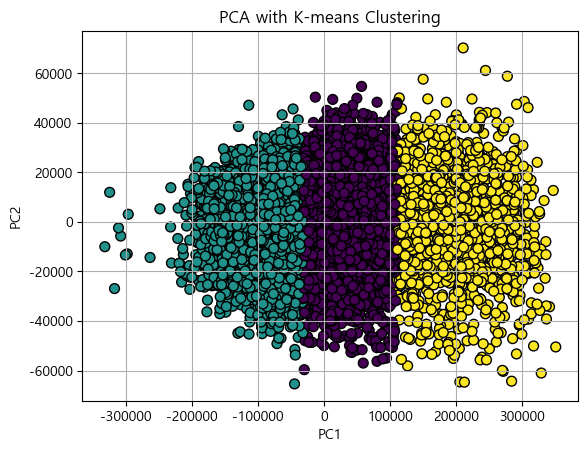

In [4]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 엑셀 파일 경로
file_path = 'your_excel_file.xlsx'

# 추출할 열 번호 리스트
columns_to_extract = [0, 3, 4, 5, 6, 8, 13, 18, 23, 28, 33, 39, 43, 47, 51, 55, 59, 64, 69, 74, 79, 84, 89, 94, 99, 104, 109, 114, 119, 124, 129, 134, 139]

# 엑셀 파일 읽기
df = pd.read_excel(file_path)

# 특정 열만 선택
extracted_df = df.iloc[:, columns_to_extract]

# 인덱스 129의 추출 후 열 번호 (추출 전 인덱스)
index_129_col = 30  # 추출된 데이터프레임에서의 위치

# 인덱스 129 열과 나머지 열로 2차원 군집분석
features_129 = extracted_df.iloc[:, index_129_col]

# 군집화 및 실루엣 계수 계산
results = []

def perform_clustering(start, end):
    for i in range(start, end):
        if i != index_129_col:
            col = extracted_df.columns[i]
            features = extracted_df[[extracted_df.columns[index_129_col], col]]

            best_k = 2
            best_score = -1
            best_model = None

            for k in range(2, 11):  # k = 2 to 10
                kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
                labels = kmeans.fit_predict(features)
                score = silhouette_score(features, labels)
                if score > best_score:
                    best_score = score
                    best_k = k
                    best_model = kmeans

            results.append({
                'feature_1': extracted_df.columns[index_129_col],
                'feature_2': col,
                'best_k': best_k,
                'best_score': best_score
            })

            # 시각화 (선택 사항)
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=features.iloc[:, 0], y=features.iloc[:, 1], hue=best_model.labels_, palette='viridis')
            plt.title(f'K-means Clustering (k={best_k}) with Features: {extracted_df.columns[index_129_col]} and {col}')
            plt.xlabel(extracted_df.columns[index_129_col])
            plt.ylabel(col)
            plt.legend(title='Cluster')
            plt.show()

# 작업을 4번으로 나누어 수행
# 첫 번째 부분 (0 ~ 7, 8개의 열)
perform_clustering(0, 8)

# 두 번째 부분 (8 ~ 15, 8개의 열)
perform_clustering(8, 16)

# 세 번째 부분 (16 ~ 23, 8개의 열)
perform_clustering(16, 24)

# 네 번째 부분 (24 ~ 32, 9개의 열)
perform_clustering(24, 33)

# 결과 출력
for result in results:
    print(f"Feature 1: {result['feature_1']}, Feature 2: {result['feature_2']}, Best k: {result['best_k']}, Best Silhouette Score: {result['best_score']:.4f}")
